Problem Statement: Bank complaints classification into appropriate categories

# **Import Necessary Modules**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## **Read Data From CSV**
Data is being read from the file 'complaints.csv'. It contains column specifying the text of the complaint or the narrative and the category it is classified into. We can use this data to identify patterns and train a model to predict the category of the complaint based on the text.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/datasets/complaints.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162421 entries, 0 to 162420
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  162421 non-null  int64 
 1   product     162421 non-null  object
 2   narrative   162411 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


# **Identifying and cleaning null values in the dataset**
There are couple of null values in narrative column of the dataset. This information is of no use infact misleading. These values can affect model's performance or introduce bias which may lead to reduction in accuracy.


In [ ]:
data[data['narrative'].isnull()]

,Unnamed: 0,product,narrative
1089,1089,credit_reporting,NaN
3954,3954,credit_reporting,NaN
3955,3955,credit_reporting,NaN
29690,29690,credit_reporting,NaN
139436,139436,debt_collection,NaN
151052,151052,debt_collection,NaN
154494,154494,credit_reporting,NaN
156902,156902,retail_banking,NaN
158538,158538,credit_reporting,NaN
159503,159503,credit_reporting,NaN


In [ ]:
data.dropna(inplace=True)

**Renaming the columns:** Here, I am just renaming the columns so that it is easier and convinient to code and understand the dataset.

In [ ]:
data.rename(columns={"Unnamed: 0" : "id", "product" : "category", "narrative" : "complaint"}, inplace=True)
data.head()

,id,category,complaint
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


# **Duplicate data elements:**
Appearantly the dataset contains lot of duplicate complaints. There are lot of complaints which contain the exact same text but are classified under different categories. This is some lack of clarity, which can be against our purpose of forwarding the complaint to appropriate dpeartment. We should be able to categorize the complaint into single category so that we can forward the complaint to the appropriate department.

While from another pov in some cases the complaint being categorized under multiple categories may make sense but I think that can be taken as a future scope of this model.

In [ ]:
data[data.duplicated("complaint", keep=False)]

,id,category,complaint
31,31,credit_reporting,name last four s account number writing disput...
32,32,credit_reporting,name last four s account number writing disput...
42,42,credit_reporting,open account acct opened balance account acct ...
44,44,credit_reporting,open account acct opened balance account acct ...
68,68,credit_reporting,hello name trying reach several time get probl...
...,...,...,...
162416,162416,debt_collection,name
162417,162417,credit_card,name
162418,162418,debt_collection,name
162419,162419,credit_card,name


The approach I chose just drops the duplicates and keeps the first occurrence of the complaint.

In [ ]:
data.drop_duplicates("complaint", inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124472 entries, 0 to 162415
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         124472 non-null  int64 
 1   category   124472 non-null  object
 2   complaint  124472 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.8+ MB


# **Understanding the distribution of categories**
As the bar graph shows the frequency of **credit reporting**  category is abnormly high compared to other categories. This is important point in our design. Although data shows that the credit reporting complaints are common,  our model should not be biased towards predicting the complaint as credit reporting.

We need to consider using techniques like oversampling, undersampling etc in order to handle this.

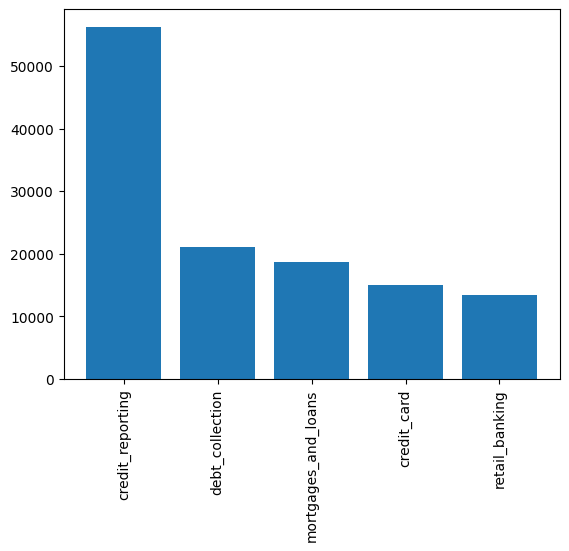

In [ ]:
freq = data.category.value_counts()
plt.bar(freq.index, freq.values)
plt.xticks(rotation=90)
plt.show()

# **Cleaning the data**
This is the most important step of the process. Here, we remove irrelevant information from the text like stopwords, punctuations, links, htmltags, etc.

This information is essentially a noice introduced during data collection process. We remove it using regular expressions.

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
import string

nltk.download("stopwords")

def clean_text(text):
    text = text.lower();
    text = re.sub(r'\[.*?]', '', text)
    url = re.compile(r'https?://\S+|www.\.\S+')
    text = url.sub(r'', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

data['complaint'] = data['complaint'].apply(lambda x: clean_text(x))
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,category,complaint
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


# **Stemming**:
Stemming is a method in text processing that eliminates prefixes and suffixes from words, transforming them into their fundamental or root form. The goal is to standardize the words into their root form so that it is easy to establish realtion between them during feaure extraction process.


In [ ]:
from nltk.stem.porter import PorterStemmer
stop_words = set(stopwords.words('english'))
# stop_words.remove('not')

ps = PorterStemmer()

def stem_text(text):
    text = [ps.stem(word) for word in text.split() if word not in stop_words]
    return ' '.join(text)

data['complaint'] = data['complaint'].apply(lambda x: stem_text(x))
data.head()

,id,category,complaint
0,0,credit_card,purchas order day ship amount receiv product w...
1,1,credit_card,forward messag date tue subject pleas investig...
2,2,retail_banking,forward messag cc sent friday pdt subject fina...
3,3,credit_reporting,payment histori miss credit report special loa...
4,4,credit_reporting,payment histori miss credit report made mistak...


# **Vectorization**
This is the step where text gets converted to numbers so that these machine learning algorithms can operate on them as they dont understand text.
So, i am using tfidf vectorizer for vectorization here it is from the scikit learn library.
Also i am pickeling the vectorizer so that i can use it for deployment.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['complaint'])
y = data['category']

with open('vectorizer_2.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

# **Training and Testing data**:
In this step we split the data into training and testing data. Essentially, we train on some data (usually 80%) and test the output of the model against the data which it hasn't seen which is testing data.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y,random_state=42)

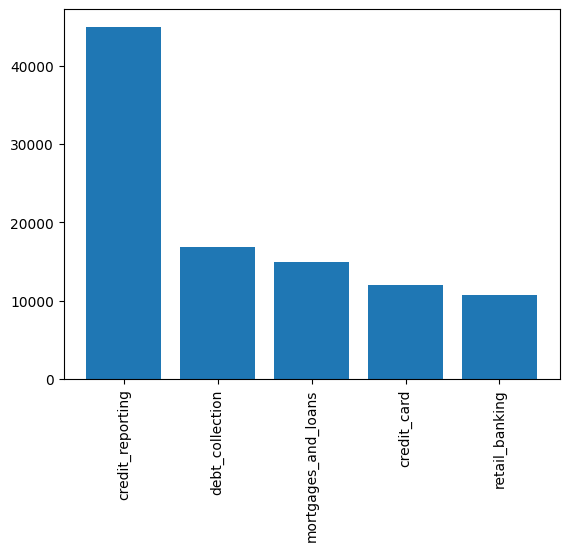

In [ ]:
freq = y_train.value_counts()
plt.bar(freq.index, freq.values)
plt.xticks(rotation=90)
plt.show()


# **Oversampling**:
In my experiments with oversampling, I found that using a random oversampler with *sampling_strategy='auto'*  resulted in a distribution where all classes had nearly the same frequency. This uniformity does not effectively address the class imbalance and can hinder model performance. To tackle this issue, I implemented a scaling factor that exponentially adjusted the number of samples for each class. This approach helped preserve the distinct characteristics of the features while still addressing the imbalance problem. As a result, I observed a notable improvement in the model’s accuracy.


Original class distribution:
credit_card: 11986
credit_reporting: 44992
debt_collection: 16846
mortgages_and_loans: 14978
retail_banking: 10775

New class distribution:
credit_card: 26752
credit_reporting: 44992
debt_collection: 37833
mortgages_and_loans: 31814
retail_banking: 22496


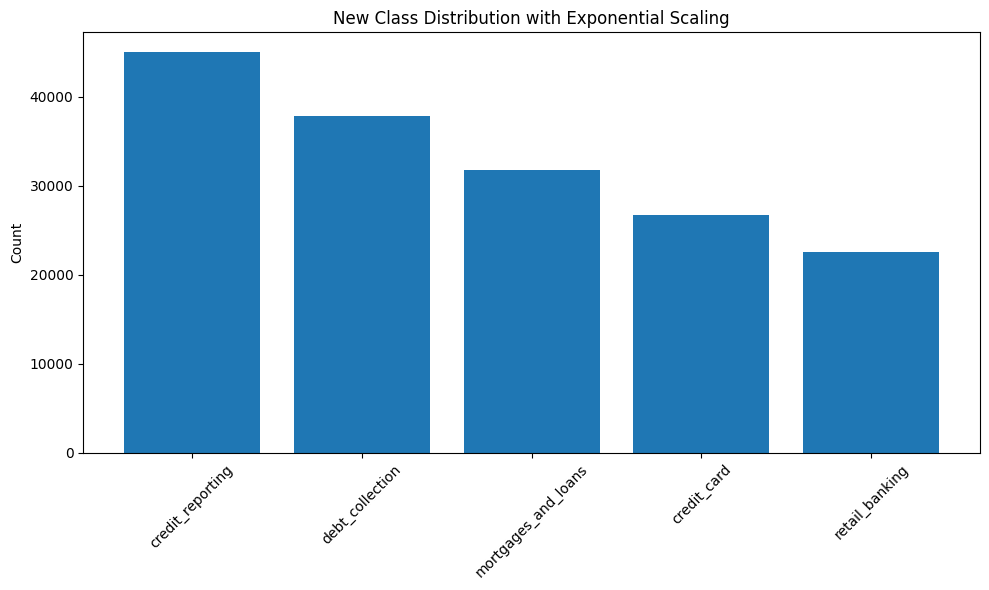

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import numpy as np

class_counts = Counter(y_train)
majority_class_size = max(class_counts.values())

def create_exponential_sampling_strategy(class_counts, base=1.5):
    classes_sorted = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
    n_classes = len(classes_sorted)

    sampling_strategy = {}
    for i, (cls, size) in enumerate(classes_sorted):
        exp_factor = base ** (-(i/(n_classes-1)))  # Will go from 1 to 1/base

        new_size = int(majority_class_size * exp_factor)

        new_size = max(new_size, size)

        sampling_strategy[cls] = new_size

    return sampling_strategy

sampling_strategy = create_exponential_sampling_strategy(class_counts, base=2.0)

ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print("Original class distribution:")
for cls, count in sorted(class_counts.items()):
    print(f"{cls}: {count}")

print("\nNew class distribution:")
new_counts = Counter(y_resampled)
for cls, count in sorted(new_counts.items()):
    print(f"{cls}: {count}")

plt.figure(figsize=(10, 6))
freq = pd.Series(y_resampled).value_counts()
plt.bar(freq.index, freq.values)
plt.title('New Class Distribution with Exponential Scaling')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **LOGISTIC REGRESSION**
accuracy: 84.99

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")

Accuracy: 0.849969873468568
F1 Score: 0.8491550671646116
Confusion Matrix:
[[ 2368   296    57    59   217]
 [  247 10065   566   309    61]
 [  111   768  3119   176    37]
 [   31   342    78  3236    58]
 [  203    45    21    53  2372]]


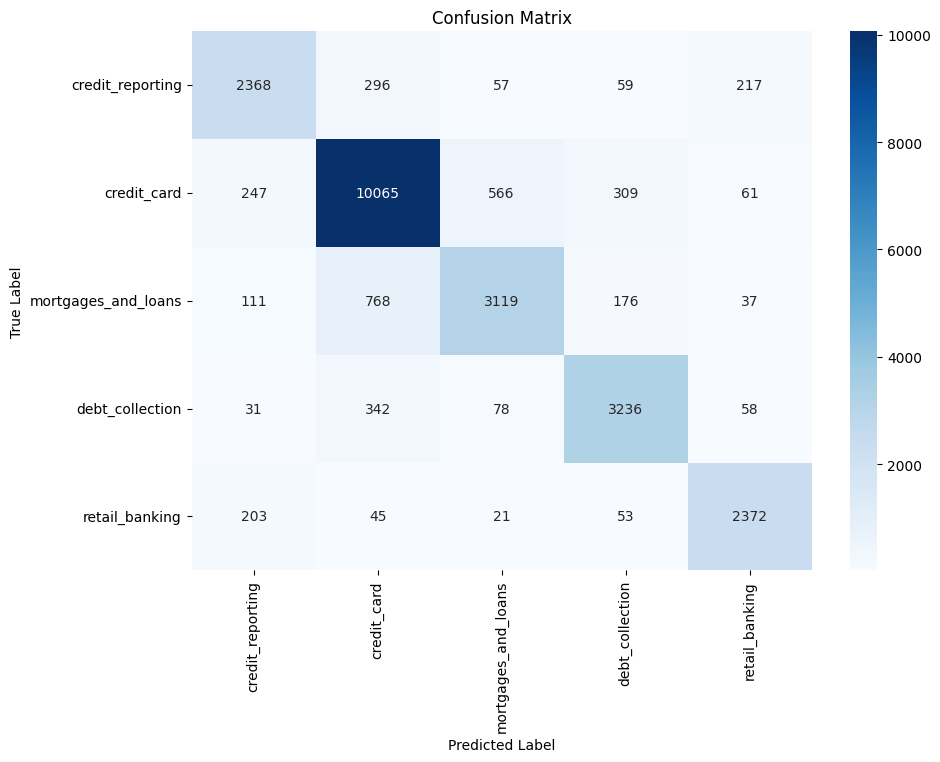

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = y_test.unique()

# Create heatmap
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
with open('logistic_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# **RANDOM FOREST CLASSIFIER**
accuracy: 85.687

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

rf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='gini')
rf.fit(X_resampled, y_resampled)

RandomForestClassifier()

In [ ]:
y_pred_rf = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf, average='weighted')}")

Accuracy: 0.8568788913436433
F1 Score: 0.8548836094045442


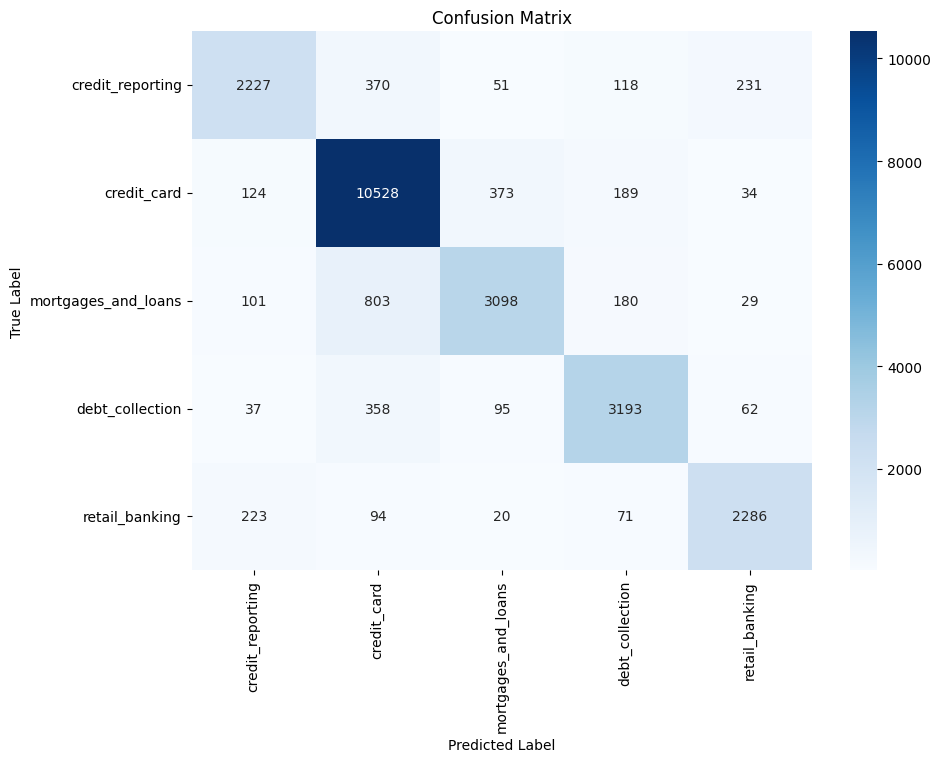

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)
class_names = y_test.unique()

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import pickle

with open('model_rf.pkl', 'wb') as file:
    pickle.dump(rf, file)

# **XGBOOST**
accuracy: 85.1415

In [ ]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

xgb_classifier = XGBClassifier(n_estimators=100, random_state=42)
xgb_classifier.fit(X_train, y_train_encoded)
y_pred_encoded = xgb_classifier.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1_score(y_test_encoded, y_pred_encoded, average='weighted')}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test_encoded, y_pred_encoded)}")

Accuracy: 0.8514159469773047
F1 Score: 0.8506598801105071
Confusion Matrix:
[[ 2336   325    69    44   223]
 [  198 10177   596   232    45]
 [  110   717  3192   155    37]
 [   38   380   111  3158    58]
 [  207    75    22    57  2333]]


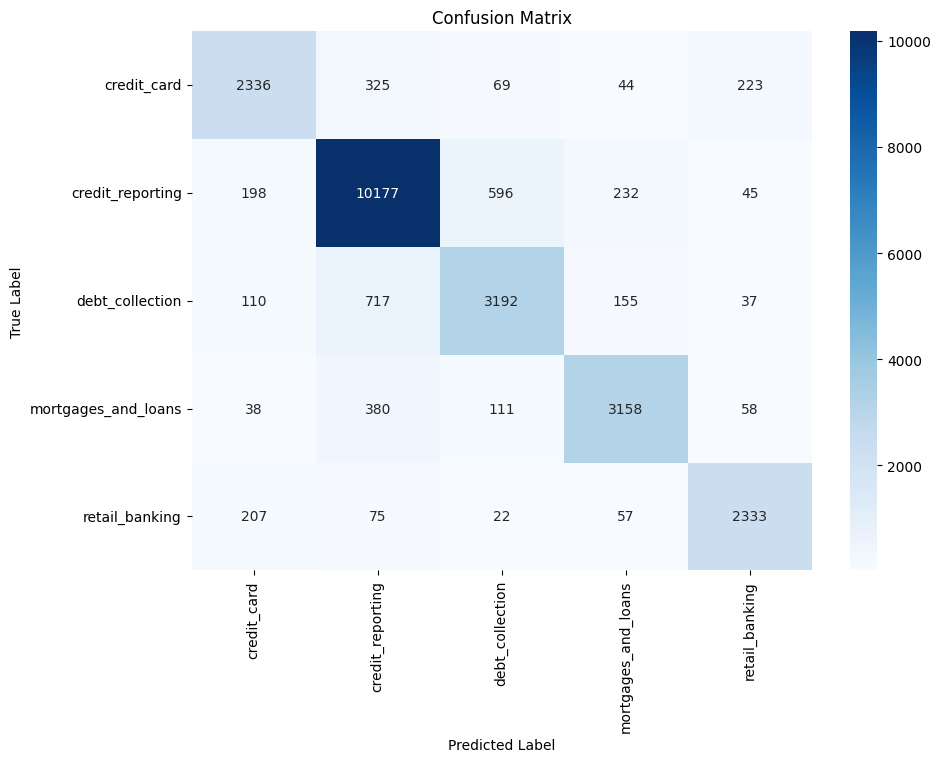

In [ ]:
conf_matrix = confusion_matrix(y_test_encoded, y_pred_encoded)

class_names = le.classes_
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_classifier, file)

# **Conclusion**
1.   In every confusion matrix, the model consistently misclassifies complaints between the 'credit card' and 'credit score' categories. Therefore, identifying specific features that distinguish these two categories and fine-tuning the current model design for optimized output will be a focus for future work in this notebook.

2.   Random Forest took highest amount of time but delivered highest accuracy

3. Finetuning transformer model like BERT may yield slightly higher accuracy




# **Deployment**
I created a simple web app which works with this model. You may visit it [here](https://bank-complaints-classification.vercel.app/)

app also has a admin portal:
admin portal login link: [admin login](https://bank-complaints-classification.vercel.app/adminlogin)

credentials for testing:


```
{
  "admin" : {
    "email" : "admin@gmail.com",
    "password" : "admin@123"
  },
  "user" : {
    "email" : "user@gmail.com",
    "password" : "user@123"
  }
}
```



some key features:
1. basic role based authentication
2. jwt based verification
3. user can submit and view the category of the complaint
4. admin can view statistics and recent complaints
5. techstack used: Flask for backend, Reactjs for frontend, Mongodb for database
6. Frontend deployed on: Vercel, Backend deployed on: Render

Future scope of this web app may be to create multiple roles and admin of specific category can see and respond to specific complaint or forward it to higher authority.